In [ ]:
!pip install tensorflow==2.3.1 gym keras-rl2 gym[atari]

!pip install gym 
!pip install 'gym[box2d]'
!pip install atari_py

!wget http://www.atarimania.com/roms/Roms.rar
!unrar x /content/Roms.rar /content
!python -m atari_py.import_roms .
!rm Roms.rar

In [2]:
import gym
import random
from gym import wrappers, envs
import numpy as np 
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os

Observation space: Box(0, 255, (210, 160, 3), uint8)
Action space: Discrete(6)
Action meanings: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


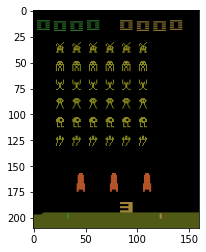

In [3]:
# env = gym.make("BreakoutNoFrameskip-v4")
# env = gym.make("MsPacmanNoFrameskip-v4")
env = gym.make("SpaceInvadersNoFrameskip-v0")

plt.imshow(env.render('rgb_array'))
plt.grid(False)

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("Action meanings:", env.env.get_action_meanings())

In [4]:
env = gym.make('SpaceInvaders-v0')
height, width, channels = env.observation_space.shape
actions = env.action_space.n

In [5]:
episodes = 7
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        env.render('rgb_array')
        action = random.choice([0,1,2,3,4,5])
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))
env.close()

Episode:1 Score:165.0
Episode:2 Score:100.0
Episode:3 Score:165.0
Episode:4 Score:75.0
Episode:5 Score:210.0
Episode:6 Score:105.0
Episode:7 Score:90.0


# DL Model

In [6]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Convolution2D
from tensorflow.keras.optimizers import Adam

In [7]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

def build_model(height, width, channels, actions):
    model = Sequential()
    model.add(Convolution2D(32, (8,8), strides=(4,4), activation='relu', input_shape=(3,height, width, channels)))
    model.add(Convolution2D(64, (4,4), strides=(2,2), activation='relu'))
    model.add(Convolution2D(64, (3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [8]:
model = build_model(height, width, channels, actions)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 51, 39, 32)     6176      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 24, 18, 64)     32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 22, 16, 64)     36928     
_________________________________________________________________
flatten (Flatten)            (None, 67584)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               34603520  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1

Keras-RL Agent

In [9]:
from rl.agents import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

In [10]:
def build_agent(model, actions):
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.2, nb_steps=10000)
    memory = SequentialMemory(limit=1000, window_length=3)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                   enable_dueling_network=True, dueling_type='avg',
                   nb_actions=actions, nb_steps_warmup=1000)
    return dqn

In [11]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-4))

In [12]:
dqn.fit(env, nb_steps=10000, visualize=False, verbose=2)

Training for 10000 steps ...
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
 1101/10000: episode: 1, duration: 112.570s, episode steps: 1101, steps per second:  10, episode reward: 225.000, mean reward:  0.204 [ 0.000, 30.000], mean action: 2.487 [0.000, 5.000],  loss: 35.614374, mean_q: 6.753126, mean_eps: 0.905455
 1671/10000: episode: 2, duration: 503.699s, episode steps: 570, steps per second:   1, episode reward: 40.000, mean reward:  0.070 [ 0.000, 20.000], mean action: 2.618 [0.000, 5.000],  loss: 0.933738, mean_q: 4.544470, mean_eps: 0.875305
 2484/10000: episode: 3, duration: 715.545s, episode steps: 813, steps per second:   1, episode reward: 210.000, mean reward:  0.258 [ 0.000, 30.000], mean action: 2.501 [0.000, 5.000],  loss: 1.010014, mean_q: 4.624712, mean_eps: 0.813070
 3029/10000: episode: 4, duration: 472.853s, episode steps: 545, steps per second:   1, episode reward: 80.000, mean reward:  0.147 [

In [1]:
scores = dqn.test(env, nb_episodes=10, visualize=True)
print(np.mean(scores.history['episode_reward']))

NameError: ignored

In [ ]:
dqn.save_weights('SavedWeights/10k-Fast/dqn_weights.h5f')